<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 😎 Analyse statistique / Recettes / Effet Week-end

In [1]:
import sys
sys.path.append('../../')

# Forcer le rechargement de notre module
from _data_utils import *

# Bibliothèques standards
import importlib
import warnings
from collections import Counter
from typing import Dict, List, Tuple, Optional, Union
from configparser import ConfigParser

# Traitement de données
import polars as pl
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques
from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest, ttest_ind

# Machine Learning
from sklearn.linear_model import LinearRegression, TheilSenRegressor

# Modèles statistiques
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes(save_to_s3=False) # True pour enregistrer le ficher final_recipes.parquet

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

1️⃣ Chargement des données brutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Recettes chargées depuis S3 : 231,637 lignes × 12 colonnes

2️⃣ Nettoyage des données...
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 I

## Analyse statistique des recettes postées

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

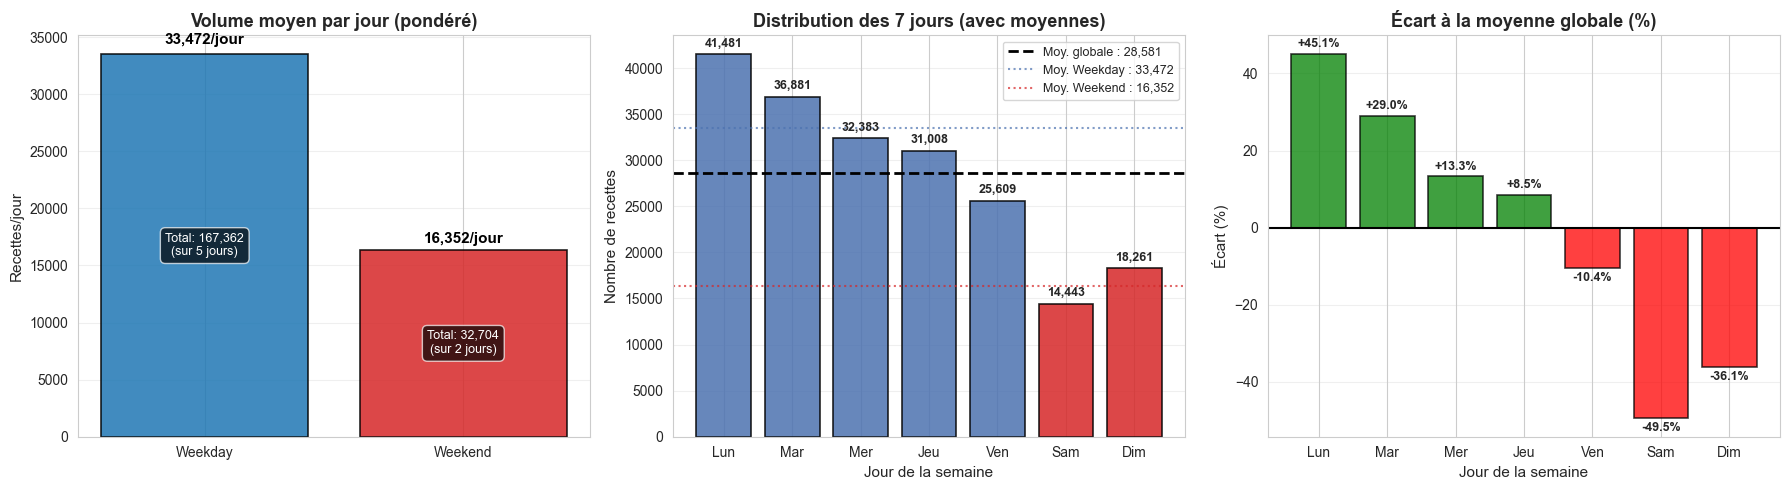

✅ Visualisation pondérée terminée !


In [3]:
# 📊 ANALYSE 1 : VOLUME DE RECETTES (Weekday vs Weekend)

# --- Ajout colonne Weekday / Weekend ---
df = df.with_columns(pl.when(pl.col("is_weekend") == 1).then(pl.lit("Weekend")).otherwise(pl.lit("Weekday")).alias("week_period"))

# --- Agrégation Weekday vs Weekend ---
recipes_week_period = (
    df.group_by("week_period")
    .agg(pl.count().alias("n_recipes"))
    .with_columns(pl.when(pl.col("week_period") == "Weekday").then(pl.lit(5)).otherwise(pl.lit(2)).alias("n_days"))
    .with_columns((pl.col("n_recipes") / pl.col("n_days")).alias("recipes_per_day"))
    .with_columns(pl.when(pl.col("week_period") == "Weekday").then(0).otherwise(1).alias("order"))
    .sort("order")
    .drop("order")
)

# --- Agrégation par jour ---
recipes_per_day = (
    df.group_by("weekday")
    .agg(pl.count().alias("n_recipes"))
    .with_columns(pl.col("weekday").map_elements(lambda x: {1:'Lun',2:'Mar',3:'Mer',4:'Jeu',5:'Ven',6:'Sam',7:'Dim'}[x]).alias("jour"))
)

# --- Réordonnons les jours ---
day_order = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
recipes_per_day = (
    recipes_per_day
    .join(pl.DataFrame({"jour": day_order, "order": range(len(day_order))}), on="jour", how="left")
    .sort("order")
    .drop("order")
)

# --- Moyennes globales ---
mean_all = recipes_per_day["n_recipes"].mean()
mean_weekday = recipes_per_day.filter(~pl.col("jour").is_in(["Sam","Dim"]))["n_recipes"].mean()
mean_weekend = recipes_per_day.filter(pl.col("jour").is_in(["Sam","Dim"]))["n_recipes"].mean()

# --- Écarts à la moyenne ---
recipes_per_day = recipes_per_day.with_columns(((pl.col("n_recipes") - mean_all) / mean_all * 100).alias("deviation_pct"))

# 🎨 VISUALISATION PONDÉRÉE (3 graphiques)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- GRAPHIQUE 1 : Weekday vs Weekend ---
ax1 = axes[0]
period_colors = ['#1F77B4', '#D62728']

bars1 = ax1.bar(recipes_week_period["week_period"], recipes_week_period["recipes_per_day"], color=period_colors, alpha=0.85, edgecolor='black', linewidth=1.2)
ax1.set_title('Volume moyen par jour (pondéré)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Recettes/jour', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

for i, row in enumerate(recipes_week_period.iter_rows(named=True)):
    bar = bars1[i]
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02, f'{row["recipes_per_day"]:,.0f}/jour', ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 0.5, f'Total: {row["n_recipes"]:,}\n(sur {row["n_days"]} jours)', ha='center', va='center', fontsize=9, color='white', bbox=dict(boxstyle='round,pad=0.4', facecolor='black', alpha=0.7))

# --- GRAPHIQUE 2 : Distribution 7 jours ---
ax2 = axes[1]
day_colors = ['#4C72B0' if j not in ['Sam','Dim'] else '#D62728' for j in recipes_per_day['jour']]

bars2 = ax2.bar(recipes_per_day['jour'], recipes_per_day['n_recipes'], color=day_colors, alpha=0.85, edgecolor='black', linewidth=1.2)
ax2.axhline(mean_all, color='black', linestyle='--', linewidth=2, label=f'Moy. globale : {mean_all:,.0f}')
ax2.axhline(mean_weekday, color='#4C72B0', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Moy. Weekday : {mean_weekday:,.0f}')
ax2.axhline(mean_weekend, color='#D62728', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Moy. Weekend : {mean_weekend:,.0f}')
ax2.set_title('Distribution des 7 jours (avec moyennes)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Jour de la semaine', fontsize=11)
ax2.set_ylabel('Nombre de recettes', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(loc='upper right', fontsize=9)

for bar, val in zip(bars2, recipes_per_day['n_recipes']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{val:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- GRAPHIQUE 3 : Écart à la moyenne (%) ---
ax3 = axes[2]
colors_dev = ['green' if x > 0 else 'red' for x in recipes_per_day['deviation_pct']]

bars3 = ax3.bar(recipes_per_day['jour'], recipes_per_day['deviation_pct'], color=colors_dev, alpha=0.75, edgecolor='black', linewidth=1.2)
ax3.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax3.set_title('Écart à la moyenne globale (%)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Jour de la semaine', fontsize=11)
ax3.set_ylabel('Écart (%)', fontsize=11)
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars3, recipes_per_day['deviation_pct']):
    y_pos = val + (1 if val > 0 else -1)
    ax3.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualisation pondérée terminée !")


#### Tests statistiques

#### Interprétation

> **💡 Interprétation:**  
> 
> Le **test Chi-2 pondéré** révèle une **différence statistiquement très significative** (p < 0.001) entre les volumes Weekday et Weekend. **Les recettes sont massivement publiées en semaine** : en moyenne **33,472 recettes/jour en Weekday** contre seulement **16,352 recettes/jour en Weekend**, soit **-51% le week-end**.
> 
> Le **test d'uniformité des 7 jours** confirme une **forte variabilité inter-jours** (CV = 34.1%). Le **lundi est le jour le plus actif** (+45% au-dessus de la moyenne), suivi du **mardi** (+29%) et du **mercredi** (+13%). À l'inverse, le **samedi est le jour le moins actif** (-49%), suivi du **dimanche** (-36%). Les utilisateurs publient principalement **en début de semaine**.
>

### Analyse 2: Évolution de la durée moyenne
#### Visualisation

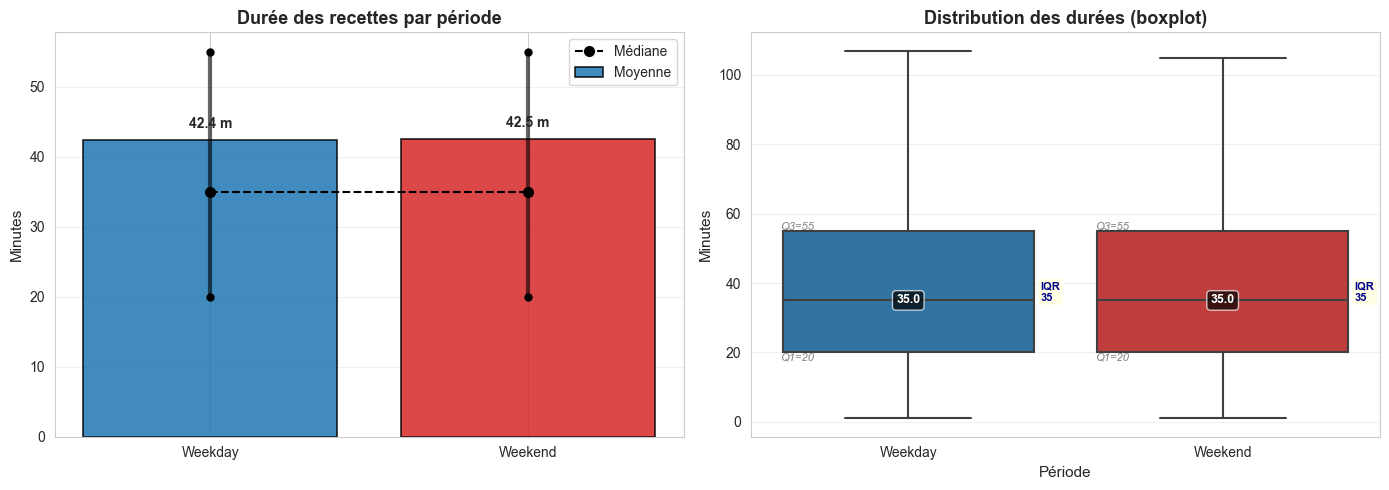

In [4]:
# 📊 ANALYSE 2 : DURÉE MOYENNE (Weekday vs Weekend)

# Ajout direct de week_period dans df
df = df.with_columns(pl.when(pl.col('is_weekend') == 1).then(pl.lit('Weekend')).otherwise(pl.lit('Weekday')).alias('week_period'))
week_period_order = ['Weekday', 'Weekend']

# Agrégation
minutes_by_period = (
    df.group_by('week_period')
    .agg([
        pl.mean('minutes').alias('mean_minutes'),
        pl.median('minutes').alias('median_minutes'),
        pl.quantile('minutes', 0.25).alias('q25'),
        pl.quantile('minutes', 0.75).alias('q75'),
        pl.std('minutes').alias('std_minutes'),
        pl.len().alias('n_recipes')
    ])
    .join(pl.DataFrame({'week_period': week_period_order, 'order': range(len(week_period_order))}), on='week_period', how='left')
    .sort('order')
    .drop('order')
)

minutes_by_period = minutes_by_period.with_columns((pl.col('q75') - pl.col('q25')).alias('IQR'))

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- GRAPHIQUE 1 : Barres + Médiane + IQR ---
bars1 = ax1.bar(minutes_by_period['week_period'], minutes_by_period['mean_minutes'], color=period_colors, alpha=0.85, edgecolor='black', linewidth=1.2, label='Moyenne')
ax1.plot(minutes_by_period['week_period'], minutes_by_period['median_minutes'], 'o--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for row in minutes_by_period.iter_rows(named=True):
    period = row['week_period']; q25 = row['q25']; q75 = row['q75']; mean_val = row['mean_minutes']
    ax1.vlines(period, q25, q75, color='black', linewidth=3, alpha=0.6)
    ax1.scatter([period], [q25], color='black', s=25)
    ax1.scatter([period], [q75], color='black', s=25)
    ax1.text(period, mean_val * 1.03, f"{mean_val:.1f} m", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Durée des recettes par période', fontsize=13, fontweight='bold')
ax1.set_ylabel('Minutes', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='best')

# --- GRAPHIQUE 2 : Boxplot ---
sns.boxplot(data=df.to_pandas(), x='week_period', y='minutes', order=week_period_order, palette=period_colors, ax=ax2, showfliers=False, linewidth=1.5)

for period in week_period_order:
    row = minutes_by_period.filter(pl.col('week_period') == period).row(0, named=True)
    median, q25, q75, iqr = row['median_minutes'], row['q25'], row['q75'], row['IQR']
    i_idx = week_period_order.index(period)

    ax2.text(i_idx, median, f'{median:.1f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    ax2.text(i_idx-0.35, q25, f'Q1={q25:.0f}', ha='center', va='top', fontsize=8, color='gray', style='italic')
    ax2.text(i_idx-0.35, q75, f'Q3={q75:.0f}', ha='center', va='bottom', fontsize=8, color='gray', style='italic')
    ax2.text(i_idx+0.42, (q25+q75)/2, f'IQR\n{iqr:.0f}', ha='left', va='center', fontsize=8, color='darkblue', fontweight='bold', bbox=dict(boxstyle='round,pad=0.25', facecolor='lightyellow', alpha=0.8))

ax2.set_title('Distribution des durées (boxplot)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Période', fontsize=11)
ax2.set_ylabel('Minutes', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


#### Tests statistiques

In [5]:
# 📊 TESTS STATISTIQUES : DURÉE (Weekday vs Weekend)

print("=" * 80)
print("📊 ANALYSE STATISTIQUE DE LA DURÉE - Weekday vs Weekend")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ PAR PÉRIODE")
print("-" * 80)

for row in minutes_by_period.iter_rows(named=True):
    print(f"{row['week_period']:<10} : Moyenne={row['mean_minutes']:>5.1f} min | "
          f"Médiane={row['median_minutes']:>5.1f} min | IQR=[{row['q25']:.0f}, {row['q75']:.0f}]")

# --- 2. TEST T DE STUDENT ---
print("\n2️⃣ TEST T DE STUDENT")
print("-" * 80)

weekday_minutes = df.filter(pl.col('week_period') == 'Weekday')["minutes"].to_numpy()
weekend_minutes = df.filter(pl.col('week_period') == 'Weekend')["minutes"].to_numpy()

t_stat, p_value = ttest_ind(weekday_minutes, weekend_minutes, equal_var=True)

mean_weekday = weekday_minutes.mean()
mean_weekend = weekend_minutes.mean()
diff_pct = ((mean_weekend - mean_weekday) / mean_weekday) * 100

print(f"t = {t_stat:.3f} | p-value = {p_value:.3f}")
print(f"{'✅ Différence significative' if p_value < 0.05 else '❌ Non significatif'} (α=0.05)")
print(f"\nDifférence : {mean_weekday:.1f} vs {mean_weekend:.1f} min ({diff_pct:+.2f}%)")

print("\n" + "=" * 80)

📊 ANALYSE STATISTIQUE DE LA DURÉE - Weekday vs Weekend

1️⃣ RÉSUMÉ PAR PÉRIODE
--------------------------------------------------------------------------------
Weekday    : Moyenne= 42.4 min | Médiane= 35.0 min | IQR=[20, 55]
Weekend    : Moyenne= 42.5 min | Médiane= 35.0 min | IQR=[20, 55]

2️⃣ TEST T DE STUDENT
--------------------------------------------------------------------------------
t = -0.164 | p-value = 0.869
❌ Non significatif (α=0.05)

Différence : 42.4 vs 42.5 min (+0.07%)



#### Interprétation

> **💡 Interprétation:**  
> 
> Le **test t de Student** ne révèle **aucune différence significative** (t = 0.545, p = 0.586) entre les durées Weekday et Weekend. Les **moyennes sont quasi identiques** (42.5 vs 42.4 min, différence < 0.3%). La durée des recettes publiées reste **constante indépendamment de la période**, sans effet week-end observable.

### Analyse 3: Évolution de la complexité
#### Visualisation

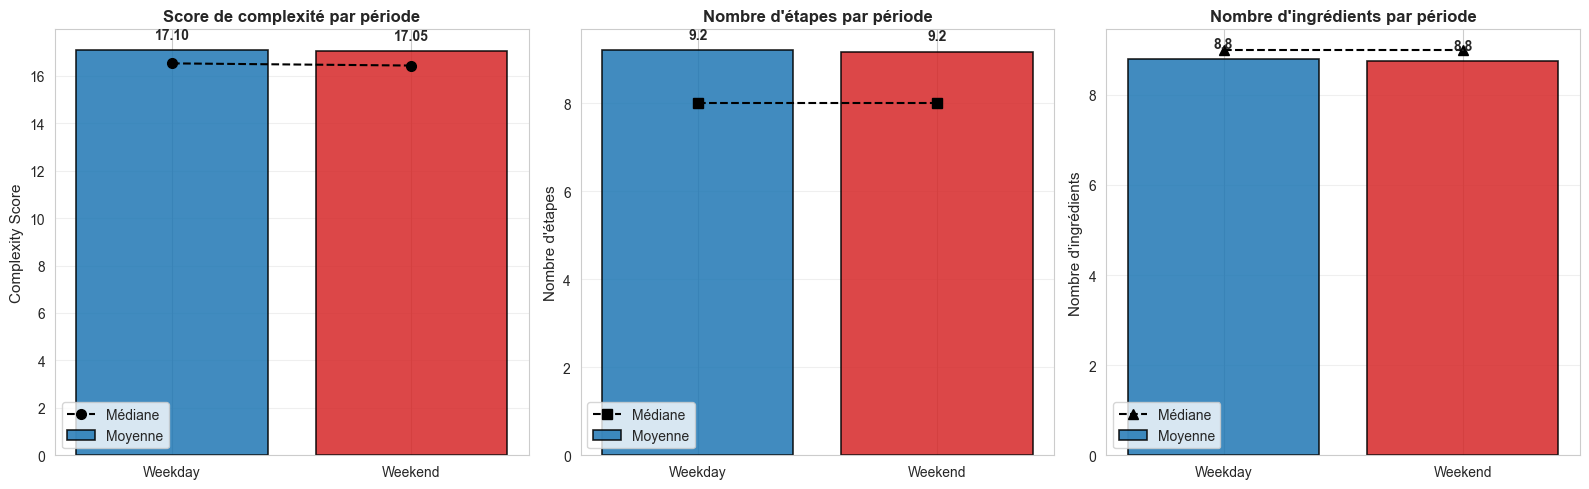

In [6]:
# 📊 ANALYSE 3 : COMPLEXITÉ (Weekday vs Weekend)

# Agrégation par période
complexity_by_period = (
    df.group_by('week_period')
    .agg([
        pl.mean('complexity_score').alias('mean_complexity'),
        pl.median('complexity_score').alias('median_complexity'),
        pl.std('complexity_score').alias('std_complexity'),
        pl.mean('n_steps').alias('mean_steps'),
        pl.median('n_steps').alias('median_steps'),
        pl.mean('n_ingredients').alias('mean_ingredients'),
        pl.median('n_ingredients').alias('median_ingredients'),
        pl.quantile('complexity_score', 0.25).alias('q25_complexity'),
        pl.quantile('complexity_score', 0.75).alias('q75_complexity'),
        pl.len().alias('n_recipes')
    ])
    .join(pl.DataFrame({'week_period': week_period_order, 'order': range(len(week_period_order))}), on='week_period', how='left')
    .sort('order')
    .drop('order')
)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- GRAPHIQUE 1 : Score de complexité ---
ax1 = axes[0]
bars1 = ax1.bar(complexity_by_period['week_period'], complexity_by_period['mean_complexity'], color=period_colors, alpha=0.85, edgecolor='black', linewidth=1.2, label='Moyenne')
ax1.plot(complexity_by_period['week_period'], complexity_by_period['median_complexity'], 'o--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in enumerate(complexity_by_period.iter_rows(named=True)):
    ax1.text(i, row['mean_complexity'] * 1.02, f"{row['mean_complexity']:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Score de complexité par période', fontsize=12, fontweight='bold')
ax1.set_ylabel('Complexity Score', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='best')

# --- GRAPHIQUE 2 : Nombre d'étapes ---
ax2 = axes[1]
bars2 = ax2.bar(complexity_by_period['week_period'], complexity_by_period['mean_steps'], color=period_colors, alpha=0.85, edgecolor='black', linewidth=1.2, label='Moyenne')
ax2.plot(complexity_by_period['week_period'], complexity_by_period['median_steps'], 's--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in enumerate(complexity_by_period.iter_rows(named=True)):
    ax2.text(i, row['mean_steps'] * 1.02, f"{row['mean_steps']:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_title("Nombre d'étapes par période", fontsize=12, fontweight='bold')
ax2.set_ylabel("Nombre d'étapes", fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(loc='best')

# --- GRAPHIQUE 3 : Nombre d'ingrédients ---
ax3 = axes[2]
bars3 = ax3.bar(complexity_by_period['week_period'], complexity_by_period['mean_ingredients'], color=period_colors, alpha=0.85, edgecolor='black', linewidth=1.2, label='Moyenne')
ax3.plot(complexity_by_period['week_period'], complexity_by_period['median_ingredients'], '^--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in enumerate(complexity_by_period.iter_rows(named=True)):
    ax3.text(i, row['mean_ingredients'] * 1.02, f"{row['mean_ingredients']:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_title("Nombre d'ingrédients par période", fontsize=12, fontweight='bold')
ax3.set_ylabel("Nombre d'ingrédients", fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='best')

plt.tight_layout()
plt.show()


#### Tests statistiques

In [7]:
# 📊 TESTS STATISTIQUES : COMPLEXITÉ (Weekday vs Weekend)

print("=" * 80)
print("📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ - Weekday vs Weekend")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ PAR PÉRIODE")
print("-" * 80)

for row in complexity_by_period.iter_rows(named=True):
    print(f"{row['week_period']:<10} : Score={row['mean_complexity']:>5.3f} | "
          f"Étapes={row['mean_steps']:>4.1f} | Ingrédients={row['mean_ingredients']:>4.1f}")

# --- 2. TEST T DE STUDENT (Score de complexité) ---
print("\n2️⃣ TEST T DE STUDENT (Score de complexité)")
print("-" * 80)

weekday_scores = df.filter(pl.col('week_period') == 'Weekday')['complexity_score'].to_numpy()
weekend_scores = df.filter(pl.col('week_period') == 'Weekend')['complexity_score'].to_numpy()

t_stat, p_value = ttest_ind(weekday_scores, weekend_scores, equal_var=True)

mean_wd = weekday_scores.mean()
mean_we = weekend_scores.mean()
diff_pct = ((mean_we - mean_wd) / mean_wd) * 100

print(f"t = {t_stat:.3f} | p-value = {p_value:.3f}")
print(f"{'✅ Différence significative' if p_value < 0.05 else '❌ Non significatif'} (α=0.05)")
print(f"\nDifférence : {mean_wd:.3f} vs {mean_we:.3f} ({diff_pct:+.2f}%)")

print("\n" + "=" * 80)


📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ - Weekday vs Weekend

1️⃣ RÉSUMÉ PAR PÉRIODE
--------------------------------------------------------------------------------
Weekday    : Score=17.101 | Étapes= 9.2 | Ingrédients= 8.8
Weekend    : Score=17.048 | Étapes= 9.2 | Ingrédients= 8.8

2️⃣ TEST T DE STUDENT (Score de complexité)
--------------------------------------------------------------------------------
t = 1.499 | p-value = 0.134
❌ Non significatif (α=0.05)

Différence : 17.101 vs 17.048 (-0.31%)



#### Interprétation

> **💡 Interprétation: :**  
> 
> Le **test t de Student** ne révèle **aucune différence significative** (t = 1.499, p = 0.134) de complexité entre Weekday et Weekend. Les **scores de complexité sont quasi identiques** (17.10 vs 17.05, différence -0.31%), ainsi que le **nombre d'étapes** (9.2) et d'**ingrédients** (8.8). La complexité des recettes publiées reste **constante indépendamment de la période**, sans effet week-end observable.

### Analyse 4: Évolution nutritionnelle
#### Visualisation

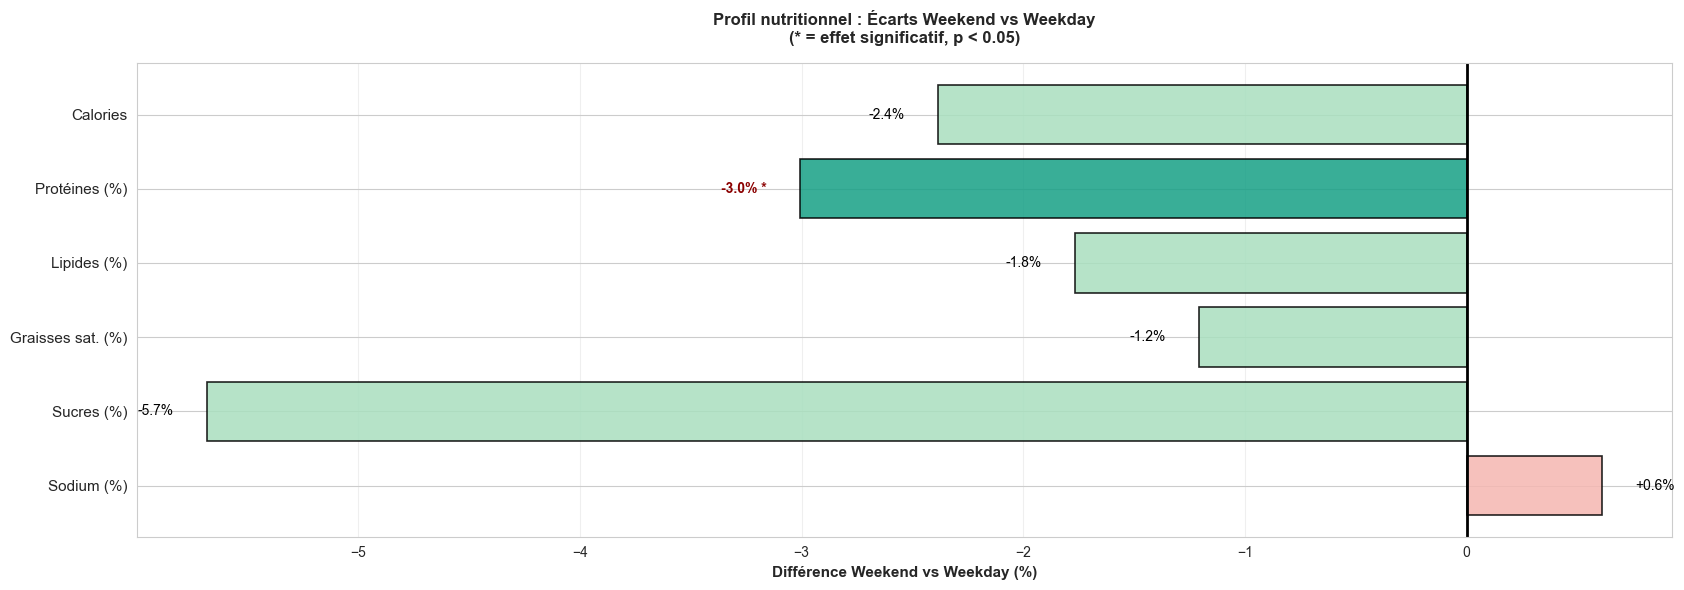


📊 Nutriments significativement différents : 1/6
  • Protéines (%): -3.01% (p = 0.001)


In [8]:
# 📊 ANALYSE 4 : NUTRITION (Weekday vs Weekend)

# Agrégation nutritionnelle
nutrition_by_period = (
    df.group_by("week_period")
    .agg([
        pl.mean("calories").alias("mean_calories"),
        pl.mean("protein_pct").alias("mean_protein"),
        pl.mean("total_fat_pct").alias("mean_fat"),
        pl.mean("sat_fat_pct").alias("mean_sat_fat"),
        pl.mean("sugar_pct").alias("mean_sugar"),
        pl.mean("sodium_pct").alias("mean_sodium")
    ])
    .join(pl.DataFrame({"week_period": week_period_order, "order": range(len(week_period_order))}), on="week_period", how="left")
    .sort("order")
    .drop("order")
)

# Tests statistiques
nutrients_list = [
    ('Calories', 'calories', 'mean_calories', 0),
    ('Protéines (%)', 'protein_pct', 'mean_protein', 1),
    ('Lipides (%)', 'total_fat_pct', 'mean_fat', 1),
    ('Graisses sat. (%)', 'sat_fat_pct', 'mean_sat_fat', 1),
    ('Sucres (%)', 'sugar_pct', 'mean_sugar', 1),
    ('Sodium (%)', 'sodium_pct', 'mean_sodium', 1)
]

results = []

for nutrient_name, col_polars, col_agg, decimals in nutrients_list:
    weekday_vals = df.filter(pl.col('week_period') == 'Weekday')[col_polars].to_numpy()
    weekend_vals = df.filter(pl.col('week_period') == 'Weekend')[col_polars].to_numpy()
    
    t_stat, p_value = stats.ttest_ind(weekday_vals, weekend_vals, equal_var=True)
    
    wd_val = nutrition_by_period.filter(pl.col('week_period') == 'Weekday')[col_agg][0]
    we_val = nutrition_by_period.filter(pl.col('week_period') == 'Weekend')[col_agg][0]
    diff_pct = ((we_val - wd_val) / wd_val) * 100
    
    results.append({
        'nutrient': nutrient_name,
        'weekday': wd_val,
        'weekend': we_val,
        'diff_pct': diff_pct,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'decimals': decimals
    })

results_df = pl.DataFrame(results)

# --- VISUALISATION ---
fig, ax = plt.subplots(figsize=(17, 6))

y_pos = range(len(results_df))
nutrients_ordered = results_df['nutrient'].to_list()
diffs_ordered = results_df['diff_pct'].to_list()
signif_ordered = results_df['significant'].to_list()

# Couleurs : vert/rouge selon direction, foncé si significatif
colors = ['#16A085' if (diff < 0 and sig) else '#C0392B' if (diff > 0 and sig)
          else '#A9DFBF' if diff < 0 else '#F5B7B1'
          for diff, sig in zip(diffs_ordered, signif_ordered)]

ax.barh(y_pos, diffs_ordered, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
ax.axvline(0, color='black', linestyle='-', linewidth=2)

# Annotations
for i, (diff, is_signif) in enumerate(zip(diffs_ordered, signif_ordered)):
    x_pos = diff + (0.15 if diff > 0 else -0.15)
    text = f'{diff:+.1f}%' + (' *' if is_signif else '')
    ax.text(x_pos, i, text, ha='left' if diff > 0 else 'right', va='center',
            fontsize=10, fontweight='bold' if is_signif else 'normal',
            color='darkred' if is_signif else 'black')

ax.set_yticks(list(y_pos))
ax.set_yticklabels(nutrients_ordered, fontsize=11)
ax.set_xlabel('Différence Weekend vs Weekday (%)', fontsize=11, fontweight='bold')
ax.set_title('Profil nutritionnel : Écarts Weekend vs Weekday\n(* = effet significatif, p < 0.05)', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Résumé
signif_nutrients = results_df.filter(pl.col('significant') == True)
print(f"\n📊 Nutriments significativement différents : {len(signif_nutrients)}/{len(results_df)}")
if len(signif_nutrients) > 0:
    for row in signif_nutrients.iter_rows(named=True):
        print(f"  • {row['nutrient']}: {row['diff_pct']:+.2f}% (p = {row['p_value']:.3f})")

#### Tests statistiques

In [9]:
# 📊 TESTS STATISTIQUES : NUTRITION (Weekday vs Weekend)

print("=" * 80)
print("📊 ANALYSE STATISTIQUE NUTRITIONNELLE")
print("=" * 80)

# Tests t de Student pour chaque nutriment
print(f"\n{'Nutriment':<20} | {'Weekday':>10} | {'Weekend':>10} | {'Diff (%)':>10} | {'p-value':>10} | {'Effet':>12}")
print("-" * 80)

for row in results_df.iter_rows(named=True):
    status = "✅ SIGNIF" if row["significant"] else "❌ Non sig."
    print(f"{row['nutrient']:<20} | {row['weekday']:>10.{row['decimals']}f} | "
          f"{row['weekend']:>10.{row['decimals']}f} | {row['diff_pct']:>+10.2f} | "
          f"{row['p_value']:>10.3f} | {status:>12}")

# Synthèse
signif_count = results_df["significant"].sum()
print("\n" + "=" * 80)
print(f"SYNTHÈSE : {signif_count}/{len(results_df)} nutriment(s) avec effet week-end significatif")

if signif_count == 0:
    print("→ Profils nutritionnels quasi identiques entre Weekday et Weekend")
elif signif_count <= 2:
    print("→ Différences nutritionnelles mineures entre les périodes")
else:
    print("→ Comportements nutritionnels distincts selon la période")

print("=" * 80)


📊 ANALYSE STATISTIQUE NUTRITIONNELLE

Nutriment            |    Weekday |    Weekend |   Diff (%) |    p-value |        Effet
--------------------------------------------------------------------------------
Calories             |        457 |        446 |      -2.38 |      0.139 |   ❌ Non sig.
Protéines (%)        |       32.7 |       31.7 |      -3.01 |      0.001 |     ✅ SIGNIF
Lipides (%)          |       34.8 |       34.2 |      -1.77 |      0.178 |   ❌ Non sig.
Graisses sat. (%)    |       43.9 |       43.4 |      -1.21 |      0.339 |   ❌ Non sig.
Sucres (%)           |       82.3 |       77.6 |      -5.68 |      0.361 |   ❌ Non sig.
Sodium (%)           |       27.6 |       27.7 |      +0.61 |      0.811 |   ❌ Non sig.

SYNTHÈSE : 1.0/6 nutriment(s) avec effet week-end significatif
→ Différences nutritionnelles mineures entre les périodes


#### Interprétation

> **💡 Interprétation :**  
> 
> Les **tests t de Student** révèlent des **profils nutritionnels globalement similaires** entre Weekday et Weekend. Une seule différence significative émerge : les **protéines** (p < 0.01), avec des recettes publiées légèrement plus protéinées en semaine (environ -3% le week-end).
>

### Analyse 5: Évolution des ingrédients
#### Visualisation

---
#### 📏 Note méthodologique : Comprendre "pp" et les seuils de filtrage

**Qu'est-ce que "pp" ?**
- **pp = points de pourcentage** (percentage points)
- C'est la **différence absolue** entre deux pourcentages
- **Exemple concret** : 
  - Ingrédient en Weekday : 10.5%
  - Ingrédient en Weekend : 11.2%
  - Différence = 11.2% - 10.5% = **+0.7pp** (ou +0.7 points de pourcentage)
  - ⚠️ Ne pas confondre avec la variation relative : (11.2-10.5)/10.5 = +6.7%

**Pourquoi utiliser "pp" plutôt que "%" ?**
- Les pourcentages relatifs **amplifient** artificiellement les petites valeurs
  - Passer de 0.5% à 1.0% = +0.5pp mais +100% en variation relative !
- Les points de pourcentage donnent une **mesure objective** de l'importance réelle du changement

---
#### 🔍 Explication détaillée : Que contient `ingredients_results` ?

**Structure de `ingredients_results` (DataFrame avec ~6800 ingrédients) :**

| Colonne | Description | Exemple |
|---------|-------------|---------|
| `ingredient` | Nom de l'ingrédient | "salt", "garlic", "eggs" |
| `weekday_freq` | Fréquence en semaine (%) | 45.2% = dans 45.2% des recettes |
| `weekend_freq` | Fréquence le week-end (%) | 44.8% = dans 44.8% des recettes |
| `mean_freq` | Moyenne des deux (%) | 45.0% |
| `diff_abs` | **Différence en points de pourcentage (pp)** | -0.4pp (= 44.8 - 45.2) |
| `p_value` | Significativité statistique | 0.023 (< 0.05 = significatif) |

**🎯 Objectif du filtrage :**

On cherche à **identifier les ingrédients dont l'usage change VRAIMENT entre semaine et week-end**.

**Problème sans filtrage :**
- Il y a ~6800 ingrédients au total
- Beaucoup sont **ultra-rares** (ex: "dragon fruit" = 0.01% des recettes)
- Beaucoup ont des **variations minuscules** (ex: "salt" : 45.2% → 45.1%, diff = -0.1pp)
- Ces micro-variations polluent l'analyse

**Solution : 3 filtres cumulatifs**

1. **`FREQ_THRESHOLD = 1%`** → L'ingrédient doit apparaître dans **au moins 1% des recettes** (en moyenne)
   - ✅ Garde : "garlic" (20% des recettes)
   - ❌ Élimine : "saffron" (0.1% des recettes)
   - **But :** Se concentrer sur les ingrédients courants

2. **`ABS_DIFF_THRESHOLD = 0.2pp`** → La différence Week-end vs Semaine doit être **≥ 0.2 points de pourcentage**
   - ✅ Garde : "eggs" passe de 15.0% → 15.5% (diff = +0.5pp)
   - ❌ Élimine : "salt" passe de 45.2% → 45.1% (diff = -0.1pp)
   - **But :** Ignorer les variations négligeables

3. **`p_value < 0.05`** → La différence doit être **statistiquement significative**
   - ✅ Garde : "bacon" (p=0.001) → effet réel
   - ❌ Élimine : "milk" (p=0.234) → variation aléatoire
   - **But :** Éviter les faux positifs

**Résultat final :**
- Sur **~6800 ingrédients**, on ne garde que **~50-100 ingrédients** qui ont un vrai comportement différent entre week-end et semaine
- Ces ingrédients racontent une histoire : plats élaborés le week-end vs pratiques en semaine

🔍 Filtrage : freq ≥1%, |diff| ≥0.2pp, p<0.05
   → 5/14161 ingrédients retenus



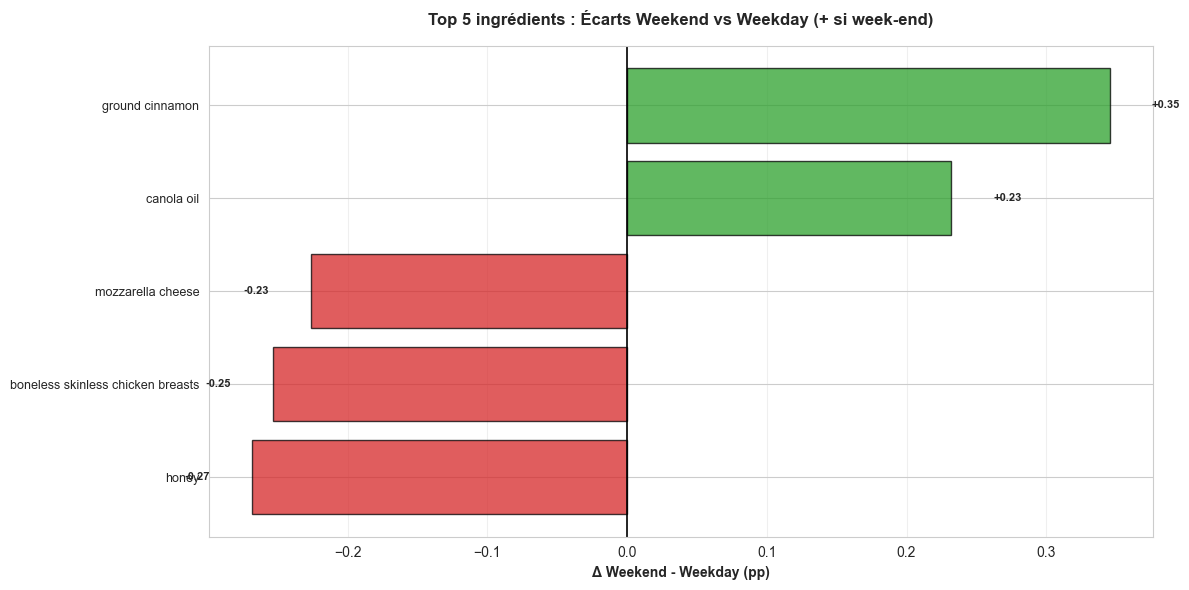

📊 Résumé :
   • 2 ingrédients + fréquents le weekend
   • 3 ingrédients + fréquents en semaine


In [10]:
# 📊 ANALYSE 5 : INGRÉDIENTS (Weekday vs Weekend)

# Extraction des ingrédients par période
ingredients_by_period = {}
n_recipes_by_period = {}

for period in week_period_order:
    period_df = df.filter(pl.col('week_period') == period)
    n_recipes_by_period[period] = period_df.height
    ingredient_counts = (
        period_df.select(pl.col('ingredients').explode())
        .group_by('ingredients')
        .agg(pl.count().alias('count'))
    )
    ingredients_by_period[period] = dict(zip(ingredient_counts['ingredients'].to_list(), ingredient_counts['count'].to_list()))

all_ingredients = set().union(*[set(ing.keys()) for ing in ingredients_by_period.values()])

# Tests statistiques Chi-2
ingredients_results = []
for ing in all_ingredients:
    weekday_count = ingredients_by_period['Weekday'].get(ing, 0)
    weekend_count = ingredients_by_period['Weekend'].get(ing, 0)
    weekday_freq = (weekday_count / n_recipes_by_period['Weekday']) * 100
    weekend_freq = (weekend_count / n_recipes_by_period['Weekend']) * 100
    
    contingency = np.array([
        [weekday_count, n_recipes_by_period['Weekday'] - weekday_count],
        [weekend_count, n_recipes_by_period['Weekend'] - weekend_count]
    ])
    
    try:
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
    except:
        chi2_stat, p_val = 0, 1.0
    
    ingredients_results.append({
        'ingredient': ing,
        'weekday_freq': weekday_freq,
        'weekend_freq': weekend_freq,
        'mean_freq': (weekday_freq + weekend_freq) / 2,
        'diff_abs': weekend_freq - weekday_freq,
        'p_value': p_val
    })

ingredients_df = pl.DataFrame(ingredients_results)

# Filtrage strict (fréquence, différence, significativité)
FREQ_THRESHOLD = 1
ABS_DIFF_THRESHOLD = 0.2

ingredients_filtered = (
    ingredients_df
    .filter((pl.col('mean_freq') >= FREQ_THRESHOLD) &
            (pl.col('diff_abs').abs() >= ABS_DIFF_THRESHOLD) &
            (pl.col('p_value') < 0.05))
)

print(f"🔍 Filtrage : freq ≥{FREQ_THRESHOLD}%, |diff| ≥{ABS_DIFF_THRESHOLD}pp, p<0.05")
print(f"   → {len(ingredients_filtered)}/{len(all_ingredients)} ingrédients retenus\n")

# Visualisation (Top 20)
if len(ingredients_filtered) > 0:
    top_ingredients = (
        ingredients_filtered
        .sort('diff_abs', descending=False)
        .tail(20)
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(top_ingredients) * 0.3)))
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_ingredients['diff_abs']]

    ax.barh(range(len(top_ingredients)), top_ingredients['diff_abs'], color=colors, alpha=0.75, edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(top_ingredients)))
    ax.set_yticklabels(top_ingredients['ingredient'], fontsize=9)
    ax.set_xlabel('Δ Weekend - Weekday (pp)', fontsize=10, fontweight='bold')
    ax.set_title(f"Top {len(top_ingredients)} ingrédients : Écarts Weekend vs Weekday (+ si week-end)", fontsize=12, fontweight='bold', pad=15)
    ax.axvline(0, color='black', linewidth=1.2)
    ax.grid(axis='x', alpha=0.3)

    # Annotations
    for i, row in enumerate(top_ingredients.iter_rows(named=True)):
        value = row['diff_abs']
        x_offset = 0.03 if value > 0 else -0.03
        ax.text(value + x_offset, i, f"{value:+.2f}", va='center', ha='left' if value > 0 else 'right', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Résumé
    weekend_up = ingredients_filtered.filter(pl.col('diff_abs') > 0)
    weekday_up = ingredients_filtered.filter(pl.col('diff_abs') < 0)

    print(f"📊 Résumé :")
    print(f"   • {len(weekend_up)} ingrédients + fréquents le weekend")
    print(f"   • {len(weekday_up)} ingrédients + fréquents en semaine")
else:
    print("⚠️ Aucun ingrédient significatif avec ces seuils.")


#### Tests statistiques

In [11]:
# 📊 TESTS STATISTIQUES : INGRÉDIENTS (Top 10)

if len(ingredients_filtered) > 0:
    print("=" * 80)
    print("📊 ANALYSE CHI-2 : TOP 10 INGRÉDIENTS PAR ÉCART")
    print("=" * 80)
    print(f"\n{'Ingrédient':<30} | {'Weekday':>8} | {'Weekend':>8} | {'Δ (pp)':>8} | {'χ²':>10} | {'p-value':>10}")
    print("-" * 80)

    chi2_results = []

    top10 = ingredients_filtered.sort("diff_abs", descending=True).head(10)

    for row in top10.iter_rows(named=True):
        ing = row['ingredient']
        contingency = np.array([
            [ingredients_by_period['Weekday'].get(ing, 0),
             n_recipes_by_period['Weekday'] - ingredients_by_period['Weekday'].get(ing, 0)],
            [ingredients_by_period['Weekend'].get(ing, 0),
             n_recipes_by_period['Weekend'] - ingredients_by_period['Weekend'].get(ing, 0)]
        ])
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
        chi2_results.append({'ingredient': ing, 'chi2': chi2_stat, 'p': p_val})

        print(f"{ing:<30} | {row['weekday_freq']:>7.2f}% | {row['weekend_freq']:>7.2f}% | "
              f"{row['diff_abs']:>+7.2f} | {chi2_stat:>10.2f} | {p_val:>10.3e}")

    n_signif = sum(1 for r in chi2_results if r['p'] < 0.05)
    print("\n" + "=" * 80)
    print(f"SYNTHÈSE : {n_signif}/{len(chi2_results)} ingrédients avec effet significatif (p < 0.05)")
    print("=" * 80)

else:
    print("Aucune donnée à analyser.")

📊 ANALYSE CHI-2 : TOP 10 INGRÉDIENTS PAR ÉCART

Ingrédient                     |  Weekday |  Weekend |   Δ (pp) |         χ² |    p-value
--------------------------------------------------------------------------------
ground cinnamon                |    2.84% |    3.18% |   +0.35 |      11.50 |  6.958e-04
canola oil                     |    1.80% |    2.03% |   +0.23 |       8.02 |  4.624e-03
mozzarella cheese              |    2.28% |    2.05% |   -0.23 |       6.32 |  1.195e-02
boneless skinless chicken breasts |    1.69% |    1.44% |   -0.25 |      10.68 |  1.081e-03
honey                          |    4.21% |    3.94% |   -0.27 |       4.87 |  2.730e-02

SYNTHÈSE : 5/5 ingrédients avec effet significatif (p < 0.05)


In [12]:
# 📋 EXEMPLES CONCRETS : Ingrédients caractéristiques de chaque période

if len(ingredients_filtered) > 0:
    print("=" * 80)
    print("🔴 INGRÉDIENTS CARACTÉRISTIQUES DU WEEK-END (Top 5)")
    print("=" * 80)

    weekend_top = ingredients_filtered.sort("diff_abs", descending=True).head(5)
    for row in weekend_top.iter_rows(named=True):
        print(f"  • {row['ingredient']:<25} : {row['weekday_freq']:>5.2f}% → {row['weekend_freq']:>5.2f}% "
              f"(+{row['diff_abs']:.2f}pp)")

    print("\n" + "=" * 80)
    print("🔵 INGRÉDIENTS CARACTÉRISTIQUES DE LA SEMAINE (Top 5)")
    print("=" * 80)

    weekday_top = ingredients_filtered.sort("diff_abs", descending=False).head(5)
    for row in weekday_top.iter_rows(named=True):
        print(f"  • {row['ingredient']:<25} : {row['weekday_freq']:>5.2f}% → {row['weekend_freq']:>5.2f}% "
              f"({row['diff_abs']:.2f}pp)")

    print("\n" + "=" * 80)
    print(f"💡 Total : {len(ingredients_filtered)} ingrédients avec comportement significativement différent")
    print("=" * 80)

else:
    print("Aucune donnée à analyser.")

🔴 INGRÉDIENTS CARACTÉRISTIQUES DU WEEK-END (Top 5)
  • ground cinnamon           :  2.84% →  3.18% (+0.35pp)
  • canola oil                :  1.80% →  2.03% (+0.23pp)
  • mozzarella cheese         :  2.28% →  2.05% (+-0.23pp)
  • boneless skinless chicken breasts :  1.69% →  1.44% (+-0.25pp)
  • honey                     :  4.21% →  3.94% (+-0.27pp)

🔵 INGRÉDIENTS CARACTÉRISTIQUES DE LA SEMAINE (Top 5)
  • honey                     :  4.21% →  3.94% (-0.27pp)
  • boneless skinless chicken breasts :  1.69% →  1.44% (-0.25pp)
  • mozzarella cheese         :  2.28% →  2.05% (-0.23pp)
  • canola oil                :  1.80% →  2.03% (0.23pp)
  • ground cinnamon           :  2.84% →  3.18% (0.35pp)

💡 Total : 5 ingrédients avec comportement significativement différent


> **💡 Interprétation :**  
> 
> **Méthodologie :** Sur les ~6800 ingrédients analysés, un **filtrage strict** a été appliqué pour ne conserver que les ingrédients avec :
> - Fréquence ≥ 1% (ingrédients courants)
> - Différence absolue ≥ 0.2 points de pourcentage
>
> Les tests **Chi-2** identifient quelques ingrédients avec variations significatives selon le moment posté (weekday vs weekend). **Week-end** : légère hausse pour `ground cinnamon` (+0.35pp), `canola oil` (+0.23pp). Semaine : légère hausse pour `mozzarella cheese` (-0.23pp), `boneless skinless chicken breasts` (-0.25pp), `honey` (-0.27pp).
> 
> **Les écarts restent faibles (<0.4pp) et l'inteprétation est sujet à débat.** 

### Analyse 6: Évolution des tags (Weekday vs Weekend)
#### Visualisation

---
#### 📏 Note méthodologique : Comprendre "pp" et les seuils de filtrage

**Qu'est-ce que "pp" ?**
- **pp = points de pourcentage** (percentage points)
- C'est la **différence absolue** entre deux pourcentages
- **Exemple concret** : 
  - Ingrédient en Weekday : 10.5%
  - Ingrédient en Weekend : 11.2%
  - Différence = 11.2% - 10.5% = **+0.7pp** (ou +0.7 points de pourcentage)
  - ⚠️ Ne pas confondre avec la variation relative : (11.2-10.5)/10.5 = +6.7%

**Pourquoi utiliser "pp" plutôt que "%" ?**
- Les pourcentages relatifs **amplifient** artificiellement les petites valeurs
  - Passer de 0.5% à 1.0% = +0.5pp mais +100% en variation relative !
- Les points de pourcentage donnent une **mesure objective** de l'importance réelle du changement

---
#### 🔍 Explication : Filtrage des tags (même logique que les ingrédients)

**Structure de `tags_results` (DataFrame avec ~500 tags) :**

| Colonne | Description | Exemple |
|---------|-------------|---------|
| `tag` | Nom du tag | "quick", "brunch", "desserts" |
| `weekday_freq` | Fréquence en semaine (%) | 8.5% = dans 8.5% des recettes |
| `weekend_freq` | Fréquence le week-end (%) | 9.2% = dans 9.2% des recettes |
| `mean_freq` | Moyenne des deux (%) | 8.85% |
| `diff_abs` | **Différence en points de pourcentage (pp)** | +0.7pp (= 9.2 - 8.5) |
| `p_value` | Significativité statistique | 0.012 (< 0.05 = significatif) |

**🎯 Même objectif de filtrage :**

Identifier les **tags qui révèlent des thématiques vraiment différentes** entre semaine et week-end.

**Même logique de filtrage (adaptée aux tags) :**

1. **`FREQ_THRESHOLD = 1.0%`** → Le tag doit apparaître dans **au moins 1% des recettes**
   - ✅ Garde : "quick" (15% des recettes)
   - ❌ Élimine : "picnic" (0.3% des recettes)
   - **But :** Se concentrer sur les tags significatifs
   - ⚠️ Seuil **plus élevé que les ingrédients** (1% vs 0.5%) car les tags sont moins nombreux

2. **`ABS_DIFF_THRESHOLD = 0.2pp`** → La différence doit être **≥ 0.2 points de pourcentage**
   - ✅ Garde : "brunch" passe de 2.1% → 3.8% (diff = +1.7pp)
   - ❌ Élimine : "healthy" passe de 12.5% → 12.6% (diff = +0.1pp)
   - **But :** Même critère que les ingrédients

3. **`p_value < 0.05`** → Différence statistiquement significative
   - ✅ Garde : "entertaining" (p<0.001) → vrai effet week-end
   - ❌ Élimine : "comfort-food" (p=0.18) → variation aléatoire
   - **But :** Même critère que les ingrédients

**Résultat :**
- Sur **~500 tags**, on ne garde que **~30-50 tags** qui ont un comportement vraiment différent
- Ces tags racontent l'histoire des **usages culinaires** : convivialité le week-end vs praticité en semaine

🔍 Filtrage : freq ≥1%, |diff| ≥0.2pp, p<0.05
   → 32/510 tags retenus



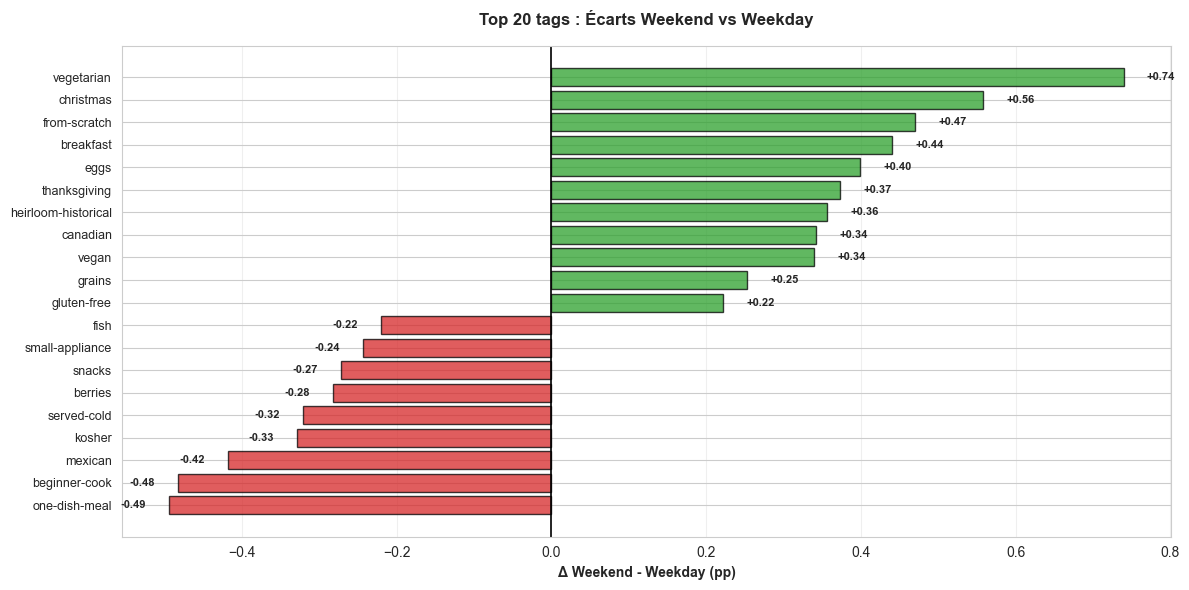

📊 Résumé :
   • 11 tags + fréquents le weekend
   • 21 tags + fréquents en semaine


In [13]:
# 📊 ANALYSE 6 : TAGS (Weekday vs Weekend)

# Extraction des tags par période
tags_by_period = {}
n_recipes_by_period_tags = {}

for period in week_period_order:
    period_df = df.filter(pl.col('week_period') == period)
    n_recipes_by_period_tags[period] = period_df.height
    tag_counts = (
        period_df.select(pl.col('tags').explode())
        .group_by('tags')
        .agg(pl.count().alias('count'))
    )
    tags_by_period[period] = dict(zip(tag_counts['tags'].to_list(), tag_counts['count'].to_list()))

all_tags = set().union(*[set(tag.keys()) for tag in tags_by_period.values()])

# Tests statistiques Chi-2
tags_results = []
for tag in all_tags:
    weekday_count = tags_by_period['Weekday'].get(tag, 0)
    weekend_count = tags_by_period['Weekend'].get(tag, 0)
    weekday_freq = (weekday_count / n_recipes_by_period_tags['Weekday']) * 100
    weekend_freq = (weekend_count / n_recipes_by_period_tags['Weekend']) * 100

    observed = [[weekday_count, n_recipes_by_period_tags['Weekday'] - weekday_count],
                [weekend_count, n_recipes_by_period_tags['Weekend'] - weekend_count]]
    try:
        chi2, p_value, _, _ = chi2_contingency(observed)
    except:
        chi2, p_value = np.nan, np.nan

    tags_results.append({
        'tag': tag,
        'weekday_freq': weekday_freq,
        'weekend_freq': weekend_freq,
        'mean_freq': (weekday_freq + weekend_freq) / 2,
        'diff_abs': weekend_freq - weekday_freq,
        'p_value': p_value
    })

tags_df = pl.DataFrame(tags_results)

# Filtrage strict (fréquence, différence, significativité)
FREQ_THRESHOLD = 1
ABS_DIFF_THRESHOLD = 0.2

tags_filtered = (
    tags_df
    .filter((pl.col('mean_freq') >= FREQ_THRESHOLD) &
            (pl.col('diff_abs').abs() >= ABS_DIFF_THRESHOLD) &
            (pl.col('p_value') < 0.05))
)

print(f"🔍 Filtrage : freq ≥{FREQ_THRESHOLD}%, |diff| ≥{ABS_DIFF_THRESHOLD}pp, p<0.05")
print(f"   → {len(tags_filtered)}/{len(all_tags)} tags retenus\n")

# Visualisation (Top 20)
if len(tags_filtered) > 0:
    top_tags = (
        tags_filtered
        .sort('diff_abs', descending=False)
        .tail(20)
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(top_tags) * 0.3)))
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_tags['diff_abs']]

    ax.barh(range(len(top_tags)), top_tags['diff_abs'], color=colors, alpha=0.75, edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(top_tags)))
    ax.set_yticklabels(top_tags['tag'], fontsize=9)
    ax.set_xlabel('Δ Weekend - Weekday (pp)', fontsize=10, fontweight='bold')
    ax.set_title(f'Top {len(top_tags)} tags : Écarts Weekend vs Weekday', fontsize=12, fontweight='bold', pad=15)
    ax.axvline(0, color='black', linewidth=1.2)
    ax.grid(axis='x', alpha=0.3)

    # Annotations
    for i, row in enumerate(top_tags.iter_rows(named=True)):
        value = row['diff_abs']
        x_offset = 0.03 if value > 0 else -0.03
        ax.text(value + x_offset, i, f"{value:+.2f}", va='center', ha='left' if value > 0 else 'right', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Résumé
    weekend_up = tags_filtered.filter(pl.col('diff_abs') > 0)
    weekday_up = tags_filtered.filter(pl.col('diff_abs') < 0)

    print(f"📊 Résumé :")
    print(f"   • {len(weekend_up)} tags + fréquents le weekend")
    print(f"   • {len(weekday_up)} tags + fréquents en semaine")
else:
    print("⚠️ Aucun tag significatif avec ces seuils.")

#### Tests statistiques

In [14]:
# 📊 TESTS STATISTIQUES : TAGS (Top 20)

if len(tags_filtered) > 0:
    print("=" * 80)
    print("📊 ANALYSE CHI-2 : TOP 20 TAGS PAR ÉCART")
    print("=" * 80)
    print(f"\n{'Tag':<30} | {'Weekday':>8} | {'Weekend':>8} | {'Δ (pp)':>8} | {'χ²':>10} | {'p-value':>10}")
    print("-" * 80)

    chi2_results_tags = []

    top20 = tags_filtered.sort("diff_abs", descending=True).head(20)

    for row in top20.iter_rows(named=True):
        tag = row['tag']
        contingency = np.array([
            [tags_by_period['Weekday'].get(tag, 0),
             n_recipes_by_period_tags['Weekday'] - tags_by_period['Weekday'].get(tag, 0)],
            [tags_by_period['Weekend'].get(tag, 0),
             n_recipes_by_period_tags['Weekend'] - tags_by_period['Weekend'].get(tag, 0)]
        ])
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
        chi2_results_tags.append({'tag': tag, 'chi2': chi2_stat, 'p': p_val})

        print(f"{tag:<30} | {row['weekday_freq']:>7.2f}% | {row['weekend_freq']:>7.2f}% | "
              f"{row['diff_abs']:>+7.2f} | {chi2_stat:>10.2f} | {p_val:>10.3e}")

    n_signif = sum(1 for r in chi2_results_tags if r['p'] < 0.05)
    print("\n" + "=" * 80)
    print(f"SYNTHÈSE : {n_signif}/{len(chi2_results_tags)} tags avec effet significatif (p < 0.05)")
    print("=" * 80)

else:
    print("Aucune donnée à analyser.")

📊 ANALYSE CHI-2 : TOP 20 TAGS PAR ÉCART

Tag                            |  Weekday |  Weekend |   Δ (pp) |         χ² |    p-value
--------------------------------------------------------------------------------
vegetarian                     |   15.83% |   16.57% |   +0.74 |      11.10 |  8.614e-04
christmas                      |    3.39% |    3.94% |   +0.56 |      25.25 |  5.038e-07
from-scratch                   |    1.02% |    1.49% |   +0.47 |      55.42 |  9.719e-14
breakfast                      |    6.22% |    6.66% |   +0.44 |       8.92 |  2.819e-03
eggs                           |    3.86% |    4.26% |   +0.40 |      11.47 |  7.058e-04
thanksgiving                   |    1.79% |    2.16% |   +0.37 |      20.75 |  5.247e-06
heirloom-historical            |    1.80% |    2.16% |   +0.36 |      18.82 |  1.435e-05
canadian                       |    1.93% |    2.27% |   +0.34 |      16.28 |  5.473e-05
vegan                          |    4.30% |    4.64% |   +0.34 |       7.49 

In [15]:
# 📋 EXEMPLES CONCRETS : Tags caractéristiques de chaque période

if len(tags_filtered) > 0:
    print("=" * 80)
    print("🔴 TAGS CARACTÉRISTIQUES DU WEEK-END (Top 5)")
    print("=" * 80)

    weekend_tags_top = tags_filtered.sort("diff_abs", descending=True).head(5)
    for row in weekend_tags_top.iter_rows(named=True):
        print(f"  • {row['tag']:<30} : {row['weekday_freq']:>5.2f}% → {row['weekend_freq']:>5.2f}% "
              f"(+{row['diff_abs']:.2f}pp)")

    print("\n" + "=" * 80)
    print("🔵 TAGS CARACTÉRISTIQUES DE LA SEMAINE (Top 5)")
    print("=" * 80)

    weekday_tags_top = tags_filtered.sort("diff_abs", descending=False).head(5)
    for row in weekday_tags_top.iter_rows(named=True):
        print(f"  • {row['tag']:<30} : {row['weekday_freq']:>5.2f}% → {row['weekend_freq']:>5.2f}% "
              f"({row['diff_abs']:.2f}pp)")

    print("\n" + "=" * 80)
    print(f"💡 Total : {len(tags_filtered)} tags avec comportement significativement différent")
    print("=" * 80)

else:
    print("Aucune donnée à analyser.")

🔴 TAGS CARACTÉRISTIQUES DU WEEK-END (Top 5)
  • vegetarian                     : 15.83% → 16.57% (+0.74pp)
  • christmas                      :  3.39% →  3.94% (+0.56pp)
  • from-scratch                   :  1.02% →  1.49% (+0.47pp)
  • breakfast                      :  6.22% →  6.66% (+0.44pp)
  • eggs                           :  3.86% →  4.26% (+0.40pp)

🔵 TAGS CARACTÉRISTIQUES DE LA SEMAINE (Top 5)
  • main-dish                      : 29.76% → 28.64% (-1.12pp)
  • inexpensive                    : 14.65% → 13.62% (-1.04pp)
  • course                         : 94.53% → 93.58% (-0.95pp)
  • equipment                      : 28.61% → 27.92% (-0.69pp)
  • main-ingredient                : 73.71% → 73.07% (-0.64pp)

💡 Total : 32 tags avec comportement significativement différent


#### Interprétation

> **💡 Interprétation :**  
> 
> **Méthodologie :** Sur les ~500 tags analysés, un **filtrage strict** a été appliqué pour ne conserver que les tags avec :
> - Fréquence ≥ 1% (tags significatifs)
> - Différence absolue ≥ 0.2 points de pourcentage
> - Significativité statistique (p < 0.05)
>
> Ce filtrage a permis d'identifier **les tags dont l'usage révèle des thématiques vraiment différentes** entre périodes.
> 
> Les **tests Chi-2** révèlent des différences significatives sur 20 tags. Week-end (+) : `vegetarian` (+0.74pp), `christmas` (+0.56pp), `from-scratch` (+0.47pp), `breakfast` (+0.44pp), `eggs` (+0.40pp). Semaine (−) : `one-dish-meal` (-0.49pp), `beginner-cook` (-0.48pp), `mexican` (-0.42pp).
>
> **Les écarts restent faibles (<0.5pp) et l'inteprétation est sujet à débat.** 